# Low Distance Spanning Cycle
We want to find the smallest spanning cycle (we are solving the TSP Problem, with the condition that in the end the salesman has to return home as well). <br />
We are doing this with a genetic algorithm. Here are a few choices which were made, along with the reasoning behind those choices. <br />

First, the structure of the program seems a bit weird (because it is), and we are trying to accomplish the following. 
- City is our individual chromosome, which has an x and y position (as we can treat this as a euclidean problem).
- Our Gene class contains the collection of Cities, which makes up our gene.
- Our fitness is the distance, and is calculated in our Gene class, as our gene contains some fitness in this case.
- Our population consists of an original gene, which creates all of our cities. This is then copied to create the rest of our population, and then shuffled so that the composition of cities is different.
- The order of the gene.cities is the order in which our salesman travels, so it is important that we shuffle.

How exactly a genetic algorithm should work is argued. Some believe that mutation search is more effective, while others believe that crossover is more important. Biologically, there are two parents, and thus this is what inspires the search I use in this algorithm. <br />

There is code (admitably - bad practice - could make it a callable option in the future) that is commented in the genetic algorithm, which can toggle between putting emphasis on only the elite's (best fitness candidates) children, or a bigger emphasis on randomess by including the children, parents, and some other randomly chosen genes. <br />

What I have found to work best (quickest) in this case, is when we focus on random crossover with a very low chance of mutation. This was determined through experimentation, and not through any imperical math proofs. <br />

A big problem with my approach taken is that it tends to converge on a local minimum best fitness (as it focuses on only the elite children). This could (probably) be lessened with a higher mutation chance, although it may take longer for an actual solution to be converged on. <br />

When working with these genes, there are a few conditions that we have to keep in mind.

- Our entire city state MUST be in each gene's city property.
- The order of how these cities appear must be the order of which our salesman travels.
- When conducting crossover, we will take a section from parent1 and copy it into the child. We will then try to preserve the order of what is left, with minor shifts (due to non-repeatance of cities) from our second parent. Because we are working with a cycle, the start point does not matter.
- When conducting mutations, we can only swap cities. This means that if we are looking at city i and city j, the order in which they are visited are swapped.

Aside from this, everything is up to what we decide to do, from the number of parents, to the chance of crossover, to the chance of mutation, to whether we even want any of these to occur. We could also change our fitness metric (although, our point is to reduce euclidean distance), and our termination condition. As an example, we can say that if the minimum value fitness gene doesn't change within some error region in some given number of iterations, we are at a local minimum and we can converge.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

1311.660437433313
1115.1541612260112
1067.9525596759552
983.201395564517
935.7548758707467
858.4201615389187
804.6367834924262
747.3518955634232
733.8031928416134
711.5478186852124
672.6153784034118
656.1890463481441
647.1931504959275
623.2219087550177
610.9803746895815
582.8979745169095
551.8942068550194
528.1193781899664
518.4994612124611
497.5100244265761
497.5100244265761
500.3112477556607
482.79110387436907
476.0658781790232
461.9735388922961
455.1315571590313
449.0422801116226
433.82335899454233
434.568567716893
433.56664151968147
424.9432192117413
396.95196837481313
379.84927787475425
392.3976616802973
398.8995892659632
381.29922678786306
379.3174296205032
373.50493634002646
374.6542549697786
364.8684244199447
356.0685514021037
352.71356374504995
357.5297103621127
347.12285814013643
346.0961189803566
341.2301716108793
333.85559716052296
326.2800602611059
328.26337562200587
328.26337562200587
322.2869903108762
317.38816126295694
317.2128853651858
315.66289982411377
310.7718070323

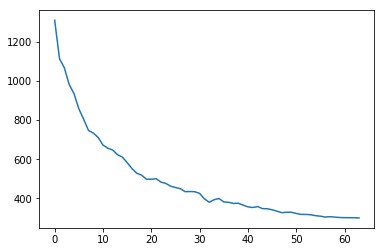

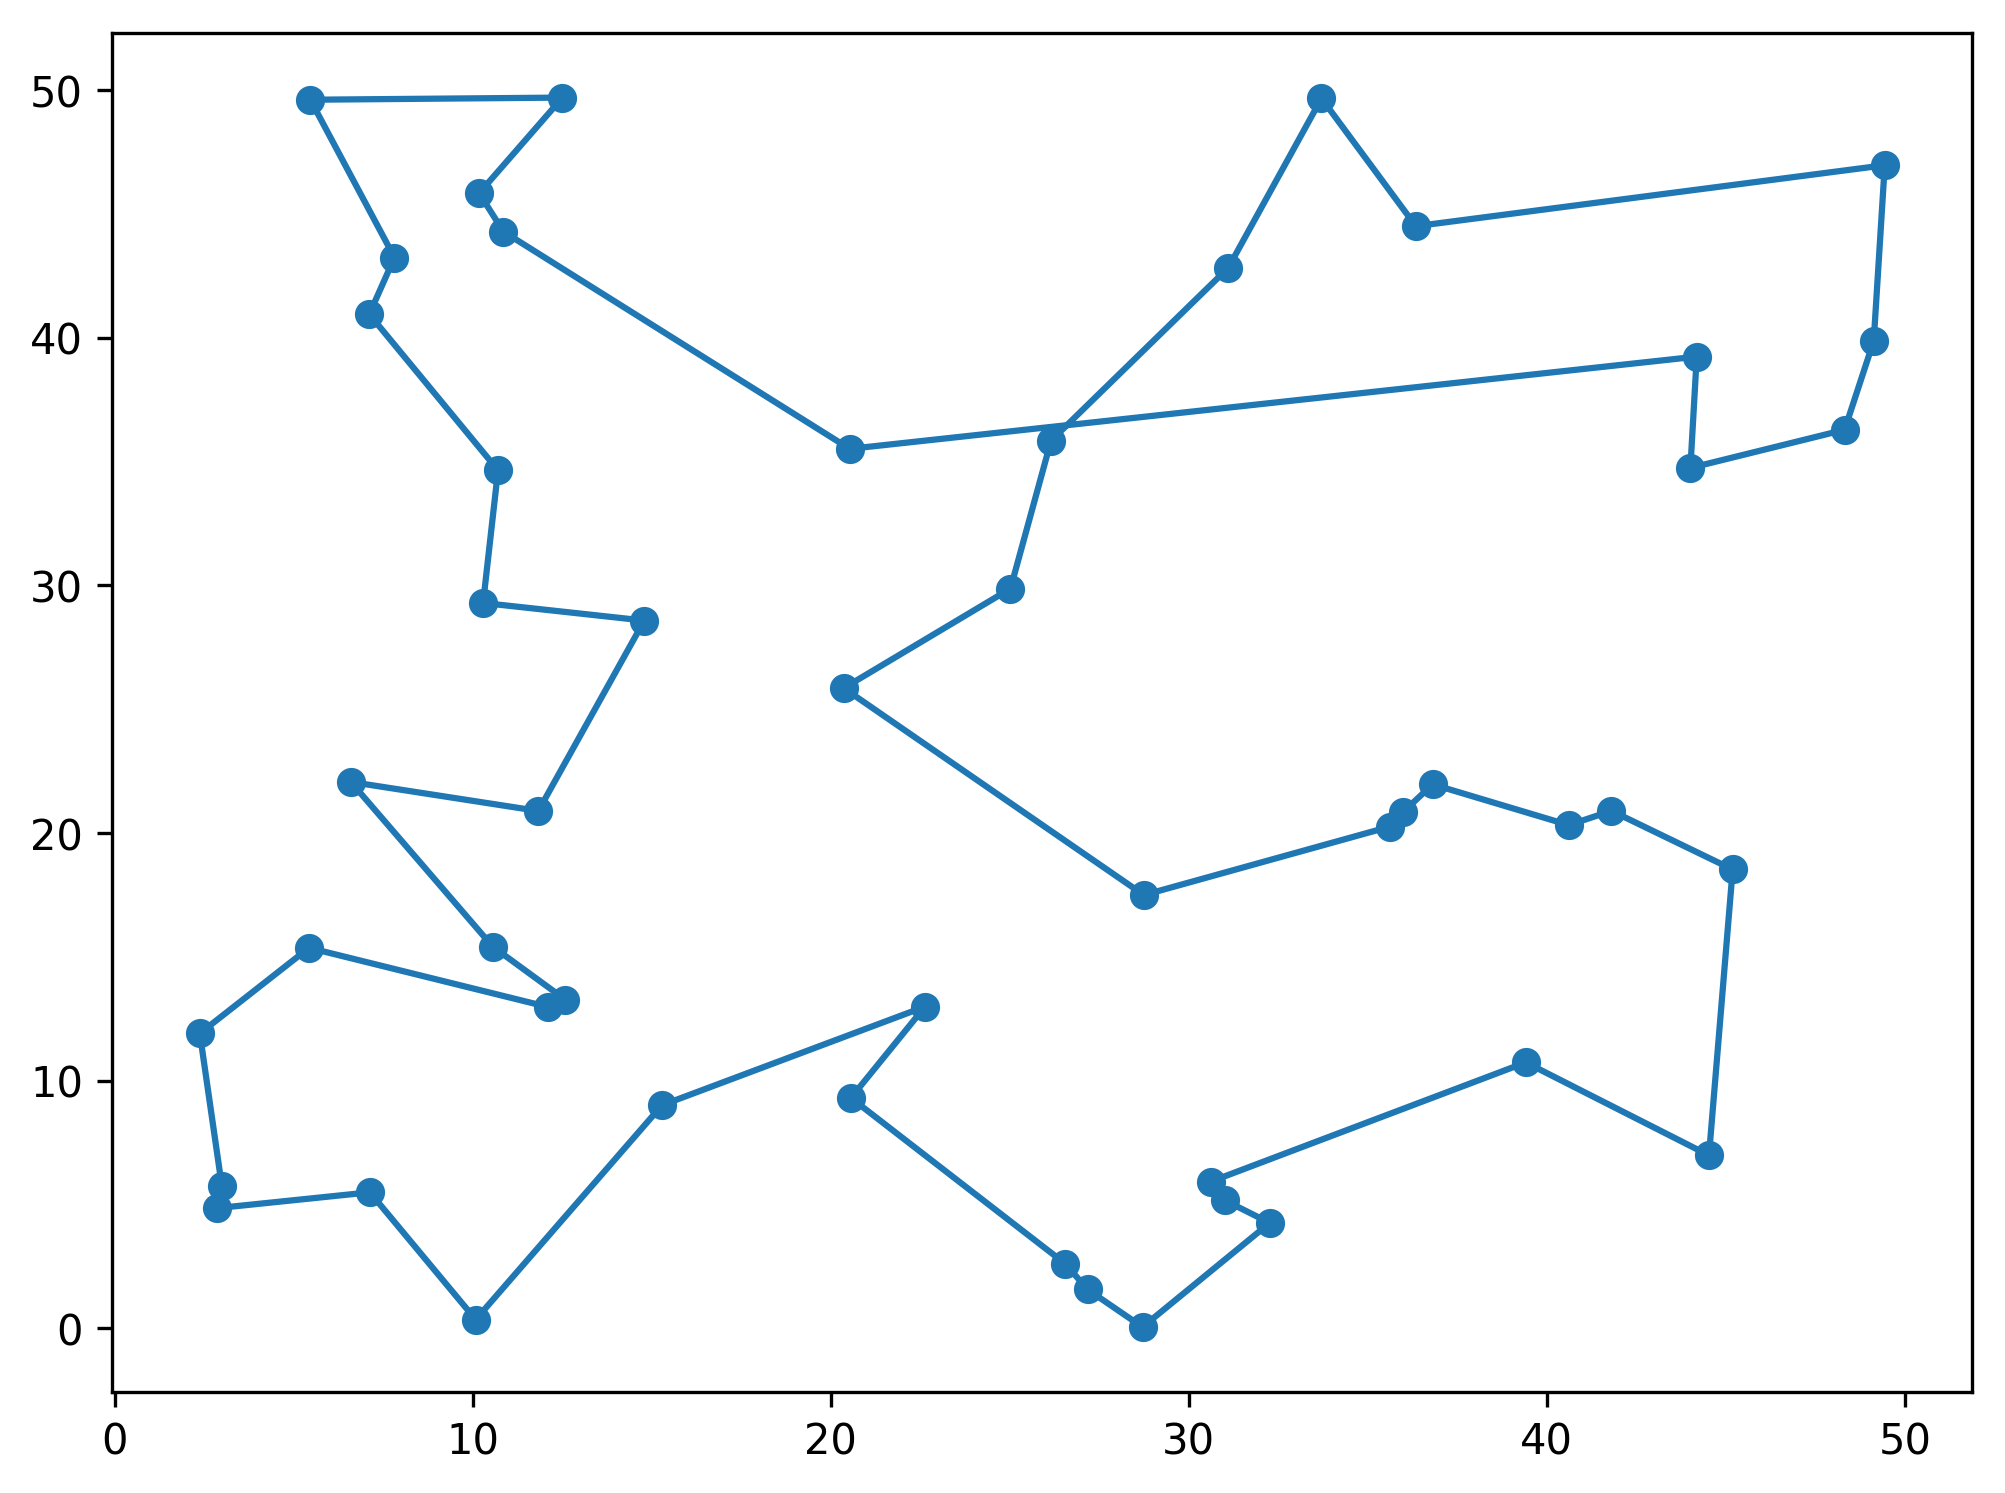

In [18]:
class City(object):
    def __init__(self, x:int = None, y:int = None, make_random:bool = True):
        self.x=0
        self.y=0
        if make_random and x is None and y is None:
            self.x = random.random()*50
            self.y = random.random()*50
        else:
            if x is not None and y is not None:
                self.x = x
                self.y = y
            else:
                print("Bad! Said not random and didn't give x, y")
    def distance_to(self, city):
        return ( (self.x - city.x)**2 + (self.y - city.y)**2 )**0.5
        
        

class Gene(object):
    def __init__(self, n:int=None, cities:list=None): # n is num points
        assert(n is not None or cities is not None)
        if cities is None and n is not None:
            self.n = n
            self.cities = [City() for _ in range(n)] # IDs of the Cities
        else:
            self.cities = cities
            self.n = len(cities)
        # NOTE: WE WANT CYCLE, SO C[0] AT FRONT AND END
        # THIS IS HOW WE WALK, SO WE WALK FROM C[0] TO C[1] ETC..
    def shuffle_chromosomes(self):
        # Restriction: We can not generate the same number twice
        random.shuffle(self.chromosomes)
    def fitness(self):
        fit = 0
        for i in range(1, self.n): # For each city
            fit += self.cities[i-1].distance_to(self.cities[i]) # Get dist
        # We also need to walk home
        fit += self.cities[-1].distance_to(self.cities[0])
        # Return this total distance
        # Our goal is going to be to minimize this (or maximize negative)
        return fit
    def mutate(self, rate): # In order to keep some randomness
        # RATE HAS TO BE A PROBABILITY
        # We do this in order to try and avoid local convergence
        assert(rate<=1 and rate>=0)

        for i in range(len(self.cities)):
            if random.random() <= rate: # If chosen to mutate
                swith = int(random.random()*self.n)
                self.cities[i], self.cities[swith] = self.cities[swith], self.cities[i]

        return # Mutated
    
def breed(gene1, gene2):
    """
    Returns a new cities array, which we can input into a new gene
    """
    child = []
    childP1 = []
    childP2 = []
    
    parent1 = gene1.cities
    parent2 = gene2.cities

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent2))

    startGene = min(geneA, geneB) # Where we start the crossover 
    endGene = max(geneA, geneB) # Where we end the crossover

    for i in range(startGene, endGene): # For the values we choose to crossover
        childP1.append(parent1[i]) # Put them in a minichild

    # Now we need to make sure that we have the same cities in the end
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2 # And now we combine the two minichildren

    return Gene(cities=child) # And form it into a Gene

def choose_elite(genes, num_elite) -> list:
    # The list is return as [elite, rest]
    elite = []
    
    fit_scores = []
    for gene in genes:
        fit_scores.append(gene.fitness())

    fit_scores = np.array(fit_scores)
    smallest = np.argpartition(fit_scores,num_elite)
    
    for i in range(num_elite):
        elite.append(genes[smallest[i]])
    
    return elite

def get_smallest_fit(genes):
    fitness = []
    for gene in genes:
        fitness.append(gene.fitness())
    min_fit = min(fitness)
    min_gene = fitness.index(min_fit)
    
    return (min_fit, genes[min_gene])
        
def get_avg_fit(genes):
    fit_scores = []
    for gene in genes:
        fit_scores.append(gene.fitness())

def greedyAlgorithm(gene):
    pass 

def geneticAlgorithm(num_cities:int, pop_size:int, fitness_thresh:float, num_elite:int, mutate_rate:float):
    assert(num_elite%2==0)
    global fitnesses
    
    main_gene = Gene(n=num_cities)
    
    genes = [Gene(cities=main_gene.cities) for i in range(pop_size)]
    
    smallest_fit, smallest_gene = float("inf"),None
    
    while fitness_thresh < smallest_fit:
        smallest_fit, smallest_gene = get_smallest_fit(genes)

        fitnesses.append(smallest_fit)
        print(smallest_fit)
        
        elites = choose_elite(genes, num_elite) # MUST BE EVEN NUM WE PICK
        children = []
        # We only keep elite crossovers
        for i in range(pop_size):
            children.append(breed(
                elites[int(random.random()*len(elites))],
                elites[int(random.random()*len(elites))]
            ))
#         #Below we keep parents, and kids, and possible randoms
#         for i in range(0,len(elites)-1,2):
#             children.append(breed(elites[i], elites[i+1])) # Add elite children
        
#         num_keep_genes = pop_size-len(children)
        
#         for i in range(num_keep_genes): # We also keep the elites
#             if i >= len(elites): # We ran out of elites!
#                 # Let's make more randoms
#                 children.append( genes[int(random.random()*len(genes))] )
#                 # It's ok if we have elites twice, we mutate
#                 # in the end anyways to try and avoid a local minimum.
#                 continue
#             children.append(elites[i])
        
        for child in children:
            child.mutate(mutate_rate) # Mutate Children
        
        genes = children
            
    return (smallest_fit, smallest_gene)



fitnesses=[]
_,min_gene = geneticAlgorithm(50, 20000, 300.0, 2000, 0.01)
print(len(min_gene.cities))

plt.plot(list(range(len(fitnesses))),fitnesses)
plt.show()
plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
xs, ys = ([city.x for city in min_gene.cities],[city.y for city in min_gene.cities])
plt.plot(xs+[xs[0]], ys+[ys[0]])
plt.scatter(xs, ys)
plt.show()

